<a href="https://colab.research.google.com/github/preetmodi/Credit-Risk-Analytics/blob/main/LGD_Caliberation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=9npNcdl%2FcBeYt95i0X1mGK83xUoajH%2FKE1saTeh5EuU'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/bin/sh: 1: open: not found
Cannot retrieve auth tokens.
Failure("Error opening URL:https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2F

In [2]:
# !pip install git+https://github.com/CBravoR/scorecardpy

%cd /content/gdrive/My Drive/Data/

/content/gdrive/My Drive/Data


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

sns.set_theme(style="darkgrid")

In [102]:
# performance_df = pd.read_pickle('model/data/performance_cleaned.pkl')
# df = pd.read_csv('LCOrigination.csv')

performance_df = pd.read_pickle('model/data/performance_with_LGD.pkl')

performance_df['id'] =  performance_df['id'].astype('int')

df = df.dropna(subset=['funded_amnt'])

df['id'] = df['id'].astype('int')

In [167]:
performance_df['funded_amnt'] = df['funded_amnt']


# LGD Calculation

In [168]:
# performance_df['loan_amnt'] = df['loan_amnt']

performance_df.columns

Index(['collection_recovery_fee', 'delinq_amnt', 'issue_d', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'pymnt_plan', 'recoveries',
       'hardship_flag', 'int_rate', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim',
       'out_prncp', 'out_prncp_inv', 'Default', 'hardship_broken',
       'next_payment_date', 'id', 'loan_amnt', 'LGD', 'term',
       'remaining_terms', 'expected_int_profit', 'loan_profit', 'funded_amnt'],
      dtype='object')

In [169]:
performance_df['EAD'] = performance_df['funded_amnt'] - performance_df['total_pymnt']

In [176]:
performance_df[(performance_df['total_pymnt'] - (performance_df['total_rec_late_fee'] + performance_df['total_rec_int'] + performance_df['total_rec_prncp']+ performance_df['recoveries'] - performance_df['collection_recovery_fee']))<-1]

,collection_recovery_fee,delinq_amnt,issue_d,last_pymnt_amnt,last_pymnt_d,loan_status,mths_since_last_delinq,mths_since_last_major_derog,pymnt_plan,recoveries,...,next_payment_date,id,loan_amnt,LGD,term,remaining_terms,expected_int_profit,loan_profit,funded_amnt,EAD


In [178]:
performance_df['LGD'] = (performance_df['total_pymnt']/performance_df['EAD'])

In [7]:
performance_df = performance_df.dropna(subset=['loan_amnt'])

In [179]:
performance_df.to_pickle('model/data/performance_with_LGD.pkl')

# Calculate Profit

In [194]:
performance_df.columns

Index(['collection_recovery_fee', 'delinq_amnt', 'issue_d', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'pymnt_plan', 'recoveries',
       'hardship_flag', 'int_rate', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim',
       'out_prncp', 'out_prncp_inv', 'Default', 'hardship_broken',
       'next_payment_date', 'id', 'loan_amnt', 'LGD', 'remaining_terms',
       'expected_int_profit', 'loan_profit', 'funded_amnt', 'EAD', 'term'],
      dtype='object')

In [189]:
performance_df = performance_df.merge(df[['id', 'term']], on='id') 
performance_df['issue_d'] = pd.to_datetime(performance_df['issue_d'])
performance_df['last_pymnt_d'] = pd.to_datetime(performance_df['last_pymnt_d'])

In [190]:
performance_df['term'] = performance_df['term'].replace({' 36 months':36, ' 60 months': 60})
# performance_df['term']
# remaining_payments = 
# performance_df.loc[performance_df['last_pymnt_d'] < performance_df['issue_d'],['loan_status','issue_d', 'last_pymnt_d']].sort_values(by=['issue_d'])
# ((performance_df['last_pymnt_d'] - performance_df['issue_d'])//np.timedelta64(1, 'M')).value_counts()

In [191]:
performance_df['remaining_terms'] = performance_df['term'] - ((performance_df['last_pymnt_d'] - performance_df['issue_d'])//np.timedelta64(1, 'M'))
performance_df['remaining_terms'] = np.where(performance_df['remaining_terms']<0, 0, performance_df['remaining_terms'])
# performance_df['term'].value_counts(dropna=False)

# performance_df.loc[performance_df['remaining_terms']<0,"loan_status"].value_counts()
# performance_df['term'] - ((performance_df['last_pymnt_d'] - performance_df['issue_d'])//np.timedelta64(1, 'M'))

# DO NOT ADD PROFIT OVER COLUMNS AS IT IS SEPERATE FOR DEFAULTERS AND NON DEFAULTERS

In [192]:
performance_df['expected_int_profit'] = (performance_df['int_rate'])/100 * performance_df['out_prncp'] * performance_df['remaining_terms']/12

# performance_df['loan_profit'] = 
# (performance_df['total_rec_int'] + performance_df['total_rec_late_fee'] + performance_df['expected_int_profit'] - performance_df['int_rate']*performance_df['loan_amnt']*performance_df['term']*0.5/100).sum()
int_revenues = performance_df['total_rec_int'] + performance_df['expected_int_profit'] 
cost = 0.5*int_revenues 
performance_df['loan_profit'] = int_revenues - cost + performance_df['total_rec_late_fee']
performance_df.loc[performance_df['Default'] ==0, 'loan_profit'].sum()
# performance_df.loc[(performance_df['total_pymnt'] + performance_df['expected_int_profit'] - ((100+performance_df['int_rate'])*performance_df['loan_amnt']*performance_df['term']*0.5/100))<0, 'loan_status'].value_counts()
# performance_df['int_rate']*performance_df['loan_amnt']*performance_df['term']*0.5/100

2235250118.204241

In [193]:
#For Defaulters

mean_LGD = performance_df.loc[performance_df['Default']==1,'LGD'].mean()
performance_df.loc[performance_df['Default']==1, 'loan_profit'] = -1*mean_LGD*performance_df['EAD']
# cost = performance_df['int_rate']*performance_df['loan_amnt']*performance_df['term']/12*0.5/100

In [195]:

performance_df.to_pickle('model/data/performance_loan_profit.pkl')

In [144]:
performance_df['int_rate']

0          11.99
1          10.78
2           8.49
3          11.48
4          12.88
           ...  
1280610    10.49
1280611    12.79
1280612    10.49
1280613    14.49
1280614    14.49
Name: int_rate, Length: 1280615, dtype: float64

In [141]:
loan_profit = (performance_df['total_rec_int'] + performance_df['total_rec_late_fee'] )

SyntaxError: ignored

In [9]:
performance_df['out_prncp']/performance_df['last_pymnt_amnt']/((performance_df['int_rate']/100)+1)

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4          17.276777
             ...    
1280641    24.483017
1280642    23.306806
1280643    24.482999
1280644     0.000000
1280645    22.427057
Length: 1280615, dtype: float64

<Axes: >

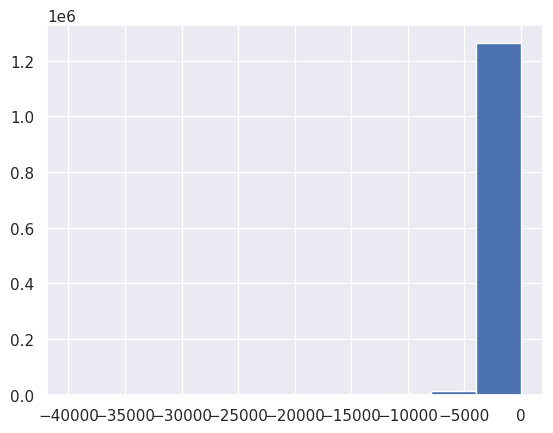

In [ ]:
(performance_df['total_rec_int'] + performance_df['total_rec_late_fee'] + performance_df['total_rec_prncp'] - performance_df['total_pymnt'])

In [ ]:
performance_df[performance_df['Default'] == 1, 'loan_amnt']performance_df[]-performance_df['total_rec_prncp']

15202165275.0

In [ ]:
performance_df['total_rec_int']

0           979.66
1          2705.92
2          1538.51
3           939.58
4          6788.21
            ...   
1280641    4928.86
1280642    6047.89
1280643    4959.95
1280644    3233.49
1280645    4027.96
Name: total_rec_int, Length: 1280615, dtype: float64

# LGD Modelling

In [ ]:
x_train, x_test, y_train, y_LGD_test = train_test_split( performance_df, # Predictors
                                                    LGD_data['LGD'],         # Target variable
                                                    test_size=0.33,          # Test size percentage
                                                    random_state=20201209    # Seed
                                                    )